In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from manual_review_classifier.Analysis import print_accuracy_and_classification_report, predict_classes

sns.set_style("white")
sns.set_context('poster')

In [4]:
training_data = pd.read_pickle('../data/training_data2.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
training_data.groupby('call').size()

call
a    14718
f     1600
g     4310
s    21159
dtype: int64

In [6]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [6]:
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [8]:
three_class.groupby('call').size()

call
a    14718
f     5910
s    21159
dtype: int64

In [9]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [10]:
X.shape

(41787, 71)

In [11]:
Y.shape

(41787,)

In [12]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [11]:
estimator = RandomForestClassifier(n_estimators=1000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

In [14]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [15]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

In [16]:
np.save('../data/random_forest/100estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [19]:
Y_one_hot = pd.get_dummies(three_class.call).astype(float).values
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.843300548017

Cross validation classification report

             precision    recall  f1-score   support

          0       0.83      0.79      0.81     14718
          1       0.74      0.78      0.76      5910
          2       0.88      0.90      0.89     21159

avg / total       0.84      0.84      0.84     41787



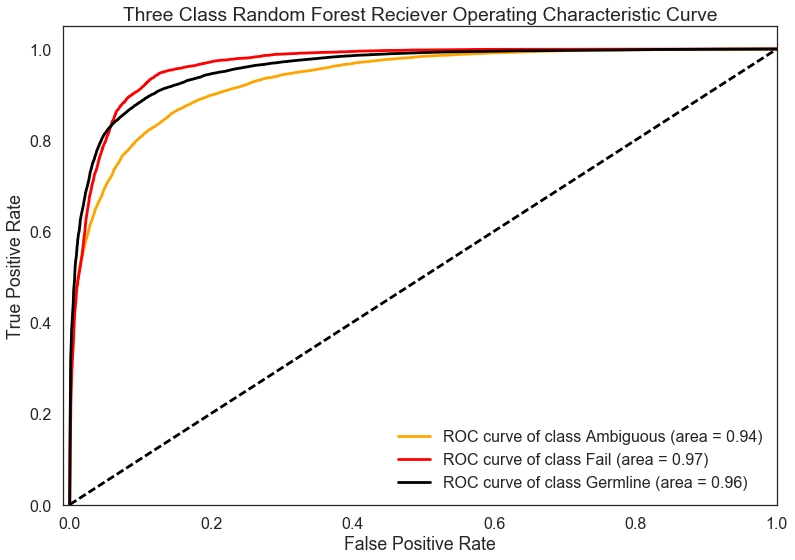

In [20]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve')

confidence intervals +-:  [ 0.00046609  0.00252458  0.0040634   0.00562486  0.00693933  0.00645748
  0.00634454  0.00505806  0.00326056  0.00093292]


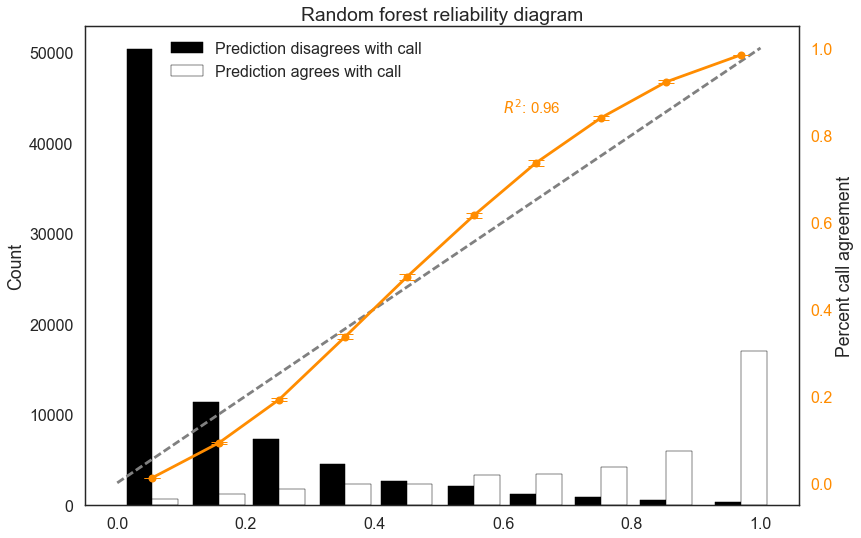

In [23]:
create_reliability_diagram(probabilities, pd.get_dummies(three_class.call).astype(float).values,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram')

confidence intervals +-:  [ 0.00158898  0.00404141  0.00615625  0.00796643  0.01101648  0.01121263
  0.01019597  0.00852526  0.00565639  0.00169975]


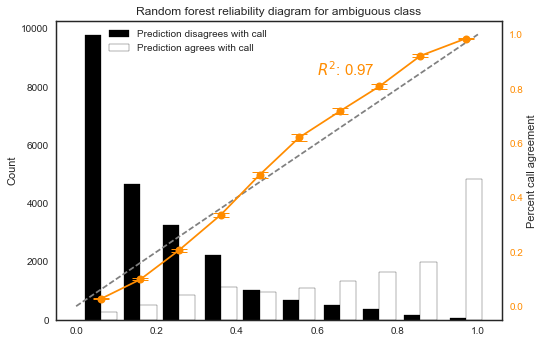

In [153]:
create_reliability_diagram(probabilities[:,:1], pd.get_dummies(three_class.call).astype(float).values[:,:1],['Ambiguous'], 'darkorange', 'Random forest reliability diagram for ambiguous class')

confidence intervals +-:  [ 0.00099275  0.00541001  0.01095516  0.01439314  0.01330964  0.01230561
  0.01246739  0.01105143  0.00809935  0.00760523]


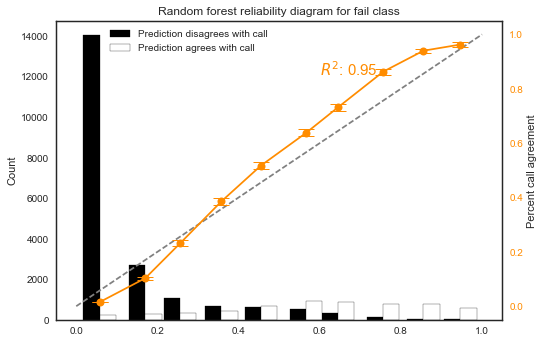

In [154]:
create_reliability_diagram(probabilities[:,1:2], pd.get_dummies(three_class.call).astype(float).values[:,1:2],['fail'], 'darkorange', 'Random forest reliability diagram for fail class')

confidence intervals +-:  [ 0.00145796  0.0042988   0.00736642  0.00980664  0.01229708  0.0106293
  0.01073421  0.00758106  0.00462862  0.00114079]


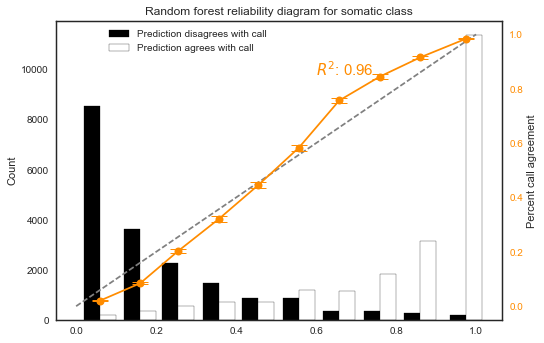

In [155]:
create_reliability_diagram(probabilities[:,2:3], pd.get_dummies(three_class.call).astype(float).values[:,2:3],['Ambiguous'], 'darkorange', 'Random forest reliability diagram for somatic class')

## Feature importance analysis

In [24]:
forest = estimator.fit(X, Y)

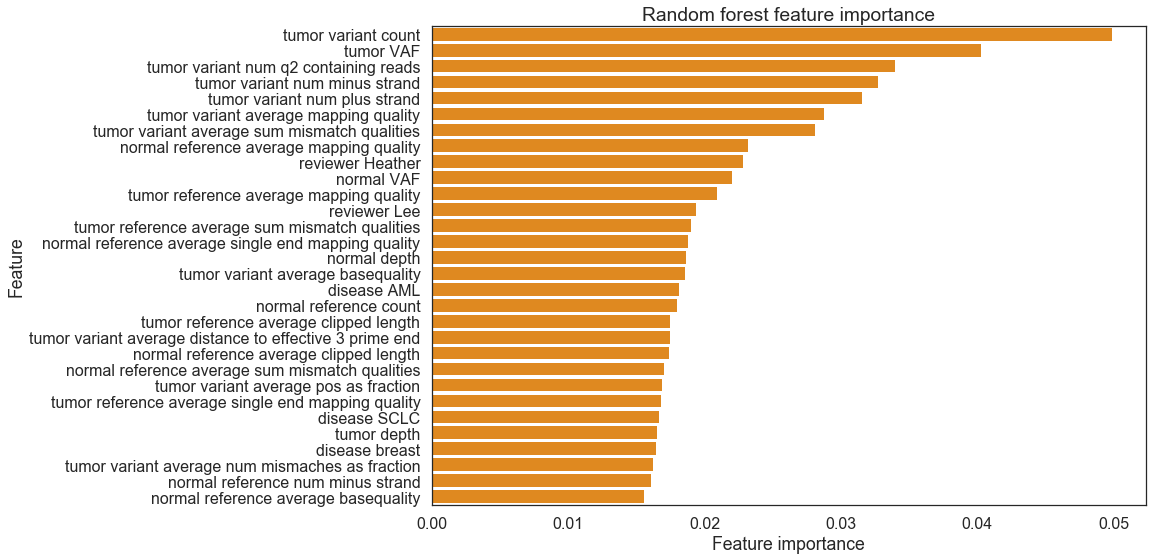

In [25]:
feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,forest.feature_importances_]).T
feature_import.columns = ['feature', 'importance']
feature_import.sort_values('importance', ascending=False, inplace=True)
feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Random forest feature importance')

## Solid vs blood tumor

In [7]:
s_v_b = three_class
#s_v_b['blood_tumor'] = s_v_b[['disease_AML','disease_lymphoma']].apply(any, axis=1).astype(int)
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [22]:
s_v_b.groupby('call').size()

call
a    14718
f     5910
s    21159
dtype: int64

In [23]:
# Get Labels
Y = s_v_b.call.values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [24]:
X.shape

(41787, 63)

In [25]:
Y.shape

(41787,)

In [26]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

In [27]:
np.save('../data/random_forest/svb.npy', probabilities)

In [28]:
probabilities = np.load('../data/random_forest/svb.npy')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [29]:
Y_one_hot = pd.get_dummies(s_v_b.call).astype(float).values
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.840524565056

Cross validation classification report

             precision    recall  f1-score   support

          0       0.82      0.78      0.80     14718
          1       0.73      0.77      0.75      5910
          2       0.88      0.90      0.89     21159

avg / total       0.84      0.84      0.84     41787



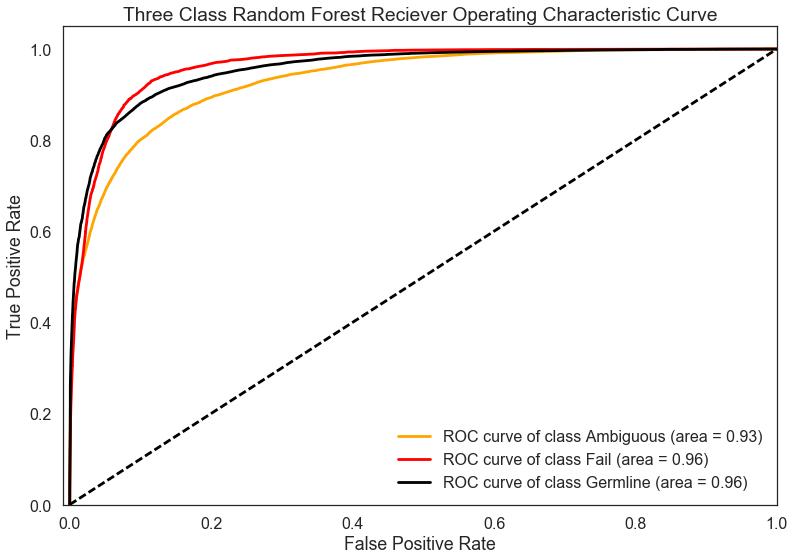

In [30]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve')

confidence intervals +-:  [ 0.00053593  0.00251485  0.00402372  0.00552752  0.0069099   0.00645995
  0.00632092  0.00501474  0.00326688  0.00096481]


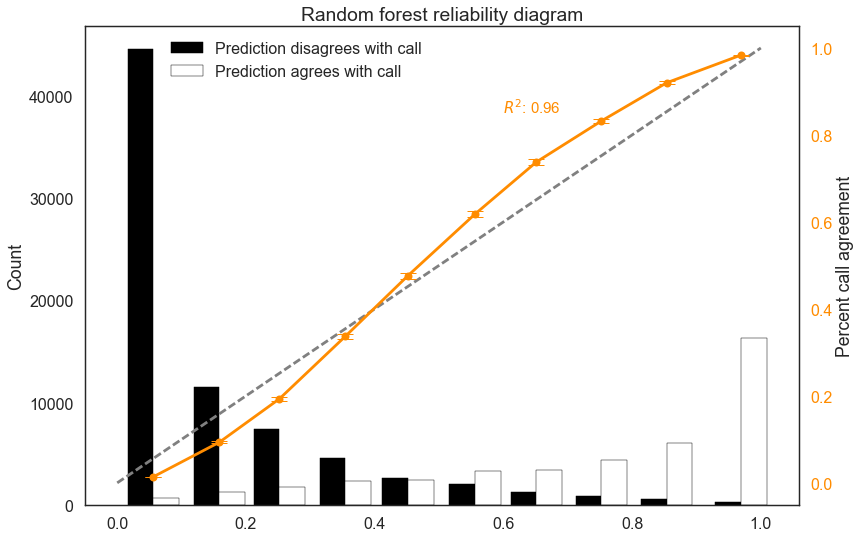

In [31]:
create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram')

## Feature importance analysis

In [80]:
forest = estimator.fit(X, Y)

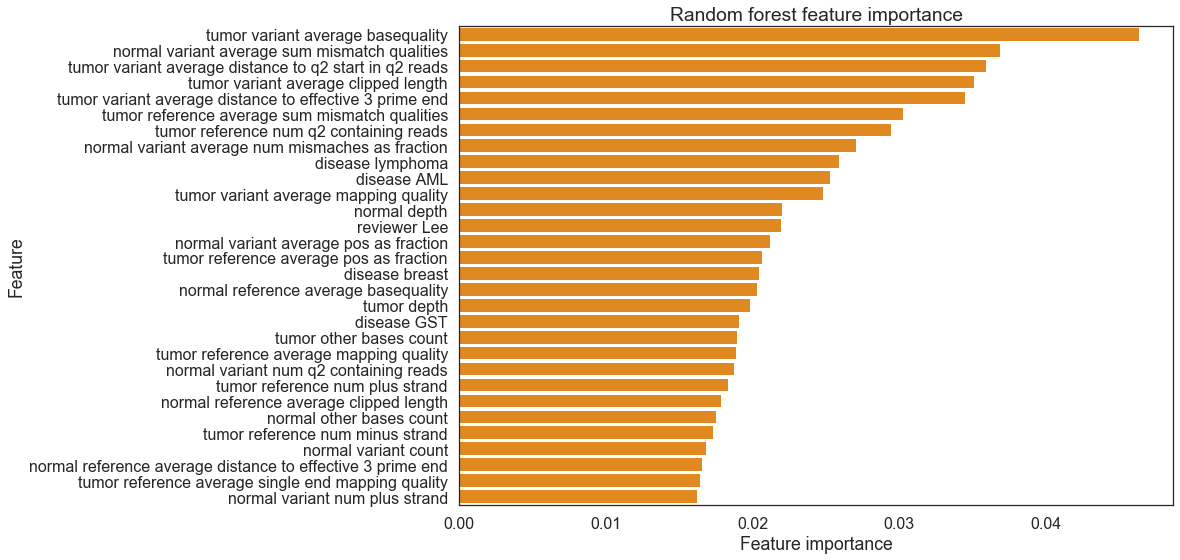

In [44]:
feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,forest.feature_importances_]).T
feature_import.columns = ['feature', 'importance']
feature_import.sort_values('importance', ascending=False, inplace=True)
feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Random forest feature importance')

# Independent test analysis

In [8]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_Lee', 'reviewer_Avi', 'reviewer_Heather', 
                'reviewer_Nick'], axis=1).astype(float).values

In [9]:
X.shape

(41787, 59)

In [10]:
Y.shape

(41787,)

In [12]:
forest = estimator.fit(X, Y)

In [13]:
# test oob score metrics
forest.oob_score_

0.83140689688180536

In [14]:
hodgkins_data = pd.read_pickle('../data/independent_test/hodgkins_lymphoma_train.pkl')
hodgkins_data.sort_index(axis=1, inplace=True)
hodgkins_data['solid_tumor'] = 0

In [15]:
hodgkins_call = pd.read_pickle('../data/independent_test/hodgkins_lymphoma_call.pkl')
hodgkins_call=hodgkins_call.map(str.lower).replace('g','f')
hodgkins_call.value_counts()

s    3187
a     240
f      85
Name: call, dtype: int64

In [16]:
# Get Labels
hodgkins_Y = hodgkins_call.values
# Get training data as numpy array
hodgkins_X = hodgkins_data.drop(['disease_lymphoma', 'reviewer_Lee',
                                 'reviewer_FG', 'reviewer_Felicia', 
                                 'reviewer_Zach'], axis=1).astype(float).values

In [17]:
hodgkins_probs = forest.predict_proba(hodgkins_X)

In [18]:
metrics.accuracy_score(hodgkins_Y, forest.predict(hodgkins_X))

0.066343963553530755

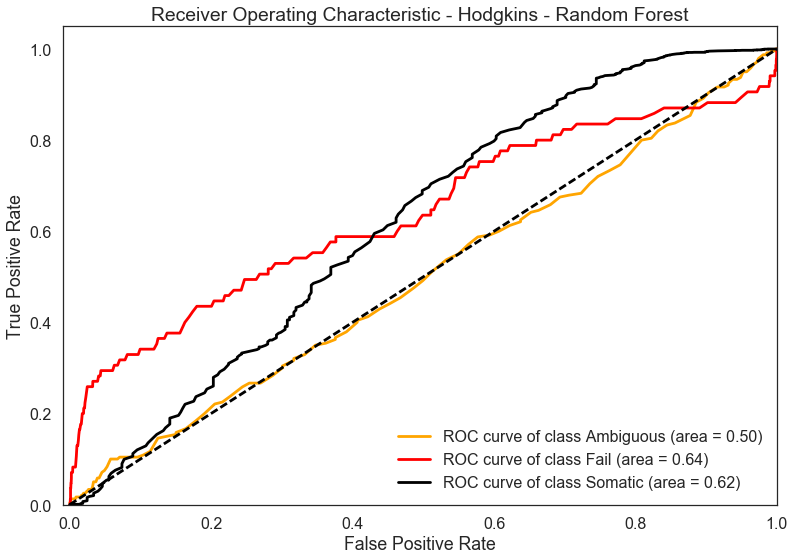

In [20]:
hY = pd.get_dummies(hodgkins_call).astype(float).values
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(hY, hodgkins_probs, class_lookup, 'Receiver Operating '
                 'Characteristic - Hodgkins - Random Forest')

In [29]:
np.set_printoptions(threshold=numpy.nan)

In [32]:
np.round(hodgkins_probs, decimals=3)

array([[ 0.425,  0.422,  0.153],
       [ 0.383,  0.358,  0.259],
       [ 0.412,  0.384,  0.204],
       [ 0.428,  0.322,  0.25 ],
       [ 0.411,  0.374,  0.215],
       [ 0.419,  0.219,  0.362],
       [ 0.438,  0.311,  0.251],
       [ 0.445,  0.206,  0.349],
       [ 0.315,  0.156,  0.529],
       [ 0.457,  0.302,  0.241],
       [ 0.444,  0.332,  0.224],
       [ 0.429,  0.391,  0.18 ],
       [ 0.434,  0.418,  0.148],
       [ 0.465,  0.42 ,  0.115],
       [ 0.472,  0.409,  0.119],
       [ 0.43 ,  0.394,  0.176],
       [ 0.442,  0.314,  0.244],
       [ 0.429,  0.322,  0.249],
       [ 0.478,  0.413,  0.109],
       [ 0.439,  0.399,  0.162],
       [ 0.438,  0.399,  0.163],
       [ 0.454,  0.317,  0.229],
       [ 0.442,  0.332,  0.226],
       [ 0.464,  0.236,  0.3  ],
       [ 0.424,  0.285,  0.291],
       [ 0.431,  0.215,  0.354],
       [ 0.468,  0.297,  0.235],
       [ 0.419,  0.271,  0.31 ],
       [ 0.453,  0.293,  0.254],
       [ 0.474,  0.218,  0.308],
       [ 0

In [31]:
hY

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.

counts [9, 311, 1807, 1122, 257, 6, 0, 0, 0, 0]
means [0.074888888888888908, 0.17409561972201607, 0.24805315324497021, 0.33073103999711362, 0.4422075564948505, 0.55283589712409853, 0.64999999999999991, 0.75, 0.85000000000000009, 0.94999999999999996]
counts [16, 252, 1691, 1711, 3299, 55, 0, 0, 0, 0]
means 

/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:61: RuntimeWarning: invalid value encountered in true_divide
  pct_positive = positive_counts / (positive_counts + negative_counts)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:70: RuntimeWarning: divide by zero encountered in true_divide
  print('confidence intervals +-: ', con_ints)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:71: RuntimeWarning: invalid value encountered in multiply
  


[0.075562500000000005, 0.17953387477152744, 0.23637844542509739, 0.34227892092284573, 0.44273541023505186, 0.51845073369853678, 0.64999999999999991, 0.75, 0.85000000000000009, 0.94999999999999996]
percent positive:  [ 0.36        0.55239787  0.5165809   0.39604659  0.07227222  0.09836066
  0.          0.          0.          0.        ]
confidence intervals +-:  [ 0.0936      0.02043255  0.00823808  0.00895893  0.0042337   0.03717636
         nan         nan         nan         nan]


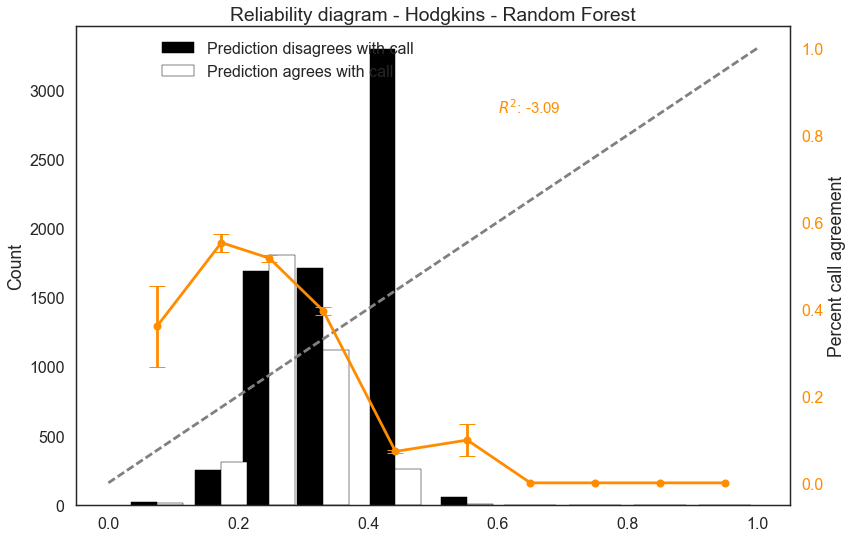

In [41]:
create_reliability_diagram(hodgkins_probs, hY,
                           ['Ambiguous','Fail','Somatic'], 
                           'darkorange', 'Reliability diagram - Hodgkins '
                           '- Random Forest')

## HCC

In [42]:
hcc_data = pd.read_pickle('../data/independent_test/hcc_train.pkl')
hcc_data['solid_tumor'] = 1

In [43]:
hcc_call = pd.read_pickle('../data/independent_test/hcc_call.pkl')
hcc_call=hcc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
hcc_call.value_counts()

s    2449
a      33
f      13
Name: call, dtype: int64

In [44]:
# Get Labels
hcc_Y = hcc_call.values
hcc_roc_labels = pd.get_dummies(hcc_call).astype(float).values
# Get training data as numpy array
hcc_X = hcc_data.drop(['disease_HCC', 'reviewer_Erica', 'reviewer_Erica ',
                                 'reviewer_Jason', 'reviewer_KK', 
                                 'reviewer_Zach'], axis=1).astype(float).values

In [45]:
hcc_probs = forest.predict_proba(hcc_X)

In [46]:
metrics.accuracy_score(hcc_Y, forest.predict(hcc_X))

0.02004008016032064

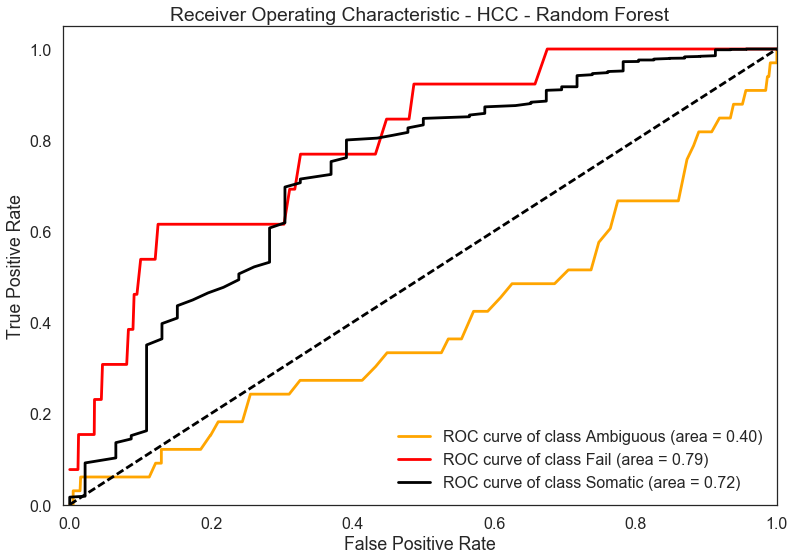

In [47]:
create_roc_curve(hcc_roc_labels, hcc_probs, class_lookup, 'Receiver '
                 'Operating Characteristic - HCC - Random Forest')

/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:59: RuntimeWarning: invalid value encountered in true_divide
  bins)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:68: RuntimeWarning: divide by zero encountered in true_divide
  inverse_n = 1/(positive_counts+negative_counts)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:69: RuntimeWarning: invalid value encountered in multiply
  con_ints = z * np.sqrt(inverse_n * pct_positive * pct_negative)


confidence intervals +-:  [ 0.          0.04873985  0.00851348  0.00840858  0.00255895  0.
         nan         nan         nan         nan]


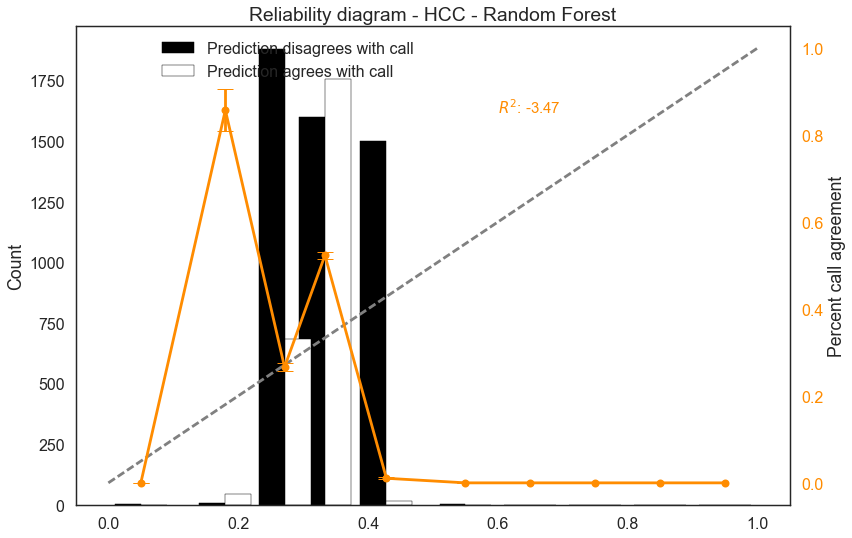

In [48]:
create_reliability_diagram(hcc_probs, hcc_roc_labels,
                           ['Ambiguous','Fail','Somatic'], 
                           'darkorange', 'Reliability diagram - HCC '
                           '- Random Forest')

## TST1 test set performance

In [49]:
tst1_data = pd.read_pickle('../manual_review_classifier/tests/test_data/training_data/train.pkl')
# tst1_data.rename(columns={'reviewer_1': 'reviewer_Lee', 'disease_BRC':'disease_breast'}, inplace=True)
# for col in ['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
#             'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
#             'disease_lymphoma', 'disease_melanoma', 'reviewer_Avi', 
#             'reviewer_Heather', 'reviewer_Nick']:
#     tst1_data[col]=0
tst1_data.sort_index(axis=1, inplace=True)
tst1_data['solid_tumor'] = 1
tst1_X = tst1_data.drop(['disease_BRC', 'reviewer_1'], axis=1).astype(float).values
tst1_calls = pd.read_pickle('../manual_review_classifier/tests/test_data/training_data/call.pkl').replace('g','f')
tst1_Y = pd.get_dummies(tst1_calls).astype(float).values

In [50]:
tst1_calls.value_counts()

s    284
a     92
f     67
Name: call, dtype: int64

In [51]:
tst1_probs = forest.predict_proba(tst1_X)

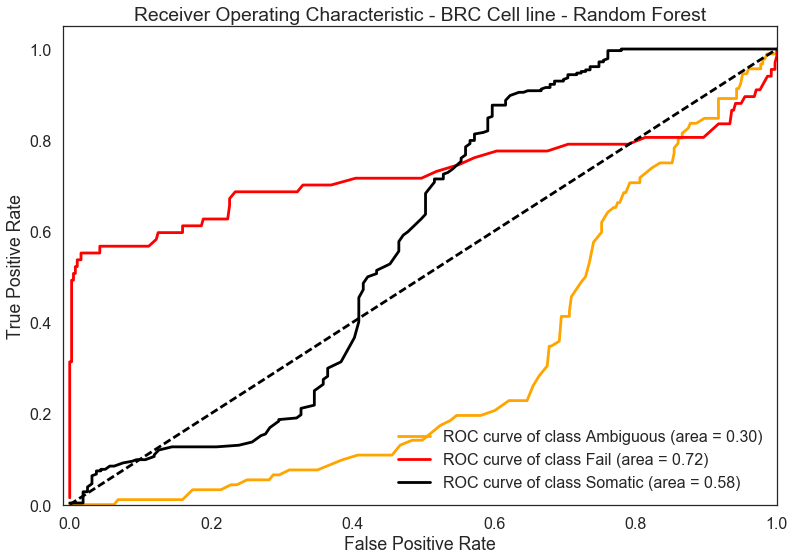

In [52]:
create_roc_curve(tst1_Y, tst1_probs, class_lookup, 'Receiver Operating '
                 'Characteristic - BRC Cell line - Random Forest')

/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:59: RuntimeWarning: invalid value encountered in true_divide
  bins)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:68: RuntimeWarning: divide by zero encountered in true_divide
  inverse_n = 1/(positive_counts+negative_counts)
/Users/bainscou/git/manual_review_classifier/manual_review_classifier/ClassifierPlots.py:69: RuntimeWarning: invalid value encountered in multiply
  con_ints = z * np.sqrt(inverse_n * pct_positive * pct_negative)


confidence intervals +-:  [ 0.          0.01393413  0.04150923  0.0256208   0.01994536  0.0589692
         nan         nan         nan         nan]


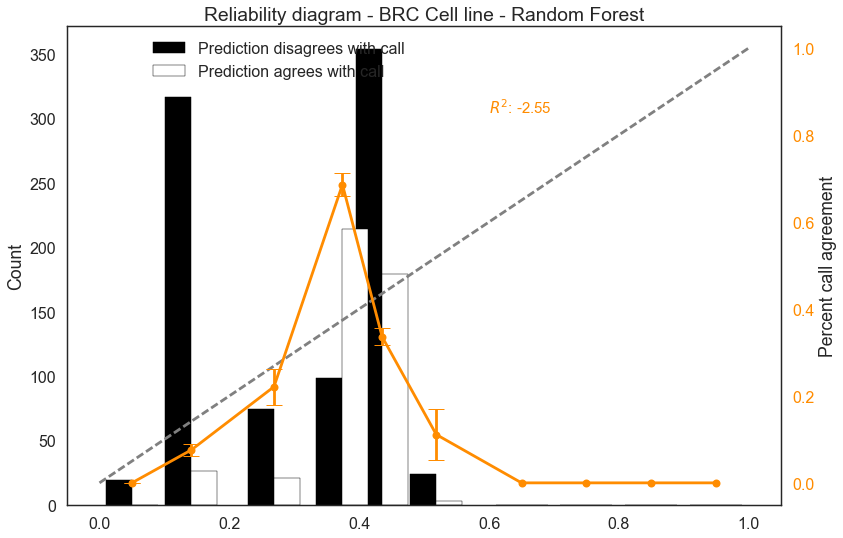

In [53]:
create_reliability_diagram(tst1_probs, tst1_Y,
                           ['Ambiguous','Fail','Somatic'], 
                           'darkorange', 'Reliability diagram - BRC Cell line '
                           '- Random Forest')

# Encorporate TST1 in training

In [53]:
(tst1_features_train, tst1_features_test, 
 tst1_calls_train, tst1_calls_test) = train_test_split(tst1_X, 
                                                       pd.read_pickle('../manual_review_classifier/tests/test_data/training_data/call.pkl').replace('g','f'), 
                                                       test_size=0.5, 
                                                       random_state=seed)

In [54]:
X_tst1 = np.concatenate((X, tst1_features_train))
Y_tst1 = np.concatenate((Y, tst1_calls_train))

In [55]:
probabilities = cross_val_predict(estimator, X_tst1, Y_tst1, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [56]:
enc = preprocessing.MultiLabelBinarizer()
labels = enc.fit_transform(Y_tst1)
print_accuracy_and_classification_report(labels, predict_classes(probabilities))

Cross validation accuracy:
	 0.831175014283

Cross validation classification report

             precision    recall  f1-score   support

          0       0.81      0.78      0.80     14761
          1       0.68      0.77      0.72      5946
          2       0.89      0.88      0.89     21301

avg / total       0.83      0.83      0.83     42008



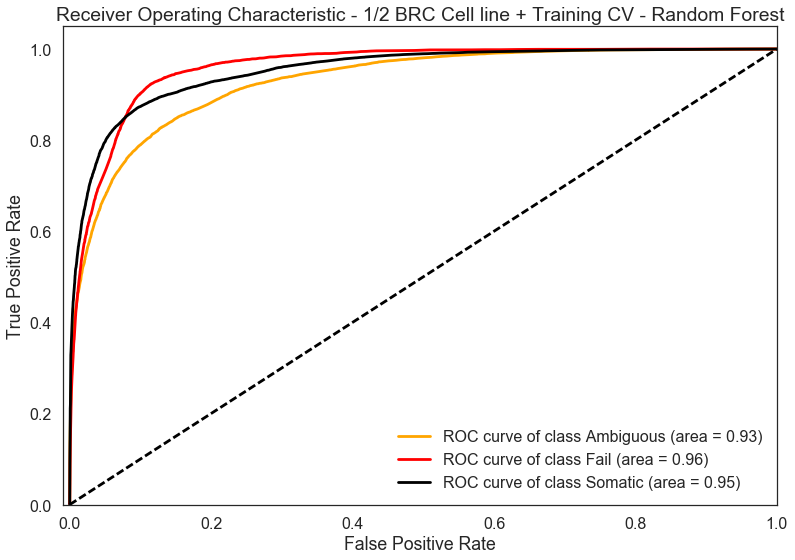

In [57]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(labels, probabilities, class_lookup, 'Receiver Operating '
                 'Characteristic - 1/2 BRC Cell line + Training CV - '
                 'Random Forest')

confidence intervals +-:  [ 0.00054306  0.00239939  0.00384122  0.00491716  0.00599247  0.00684141
  0.00599122  0.004642    0.00322229  0.00098014]


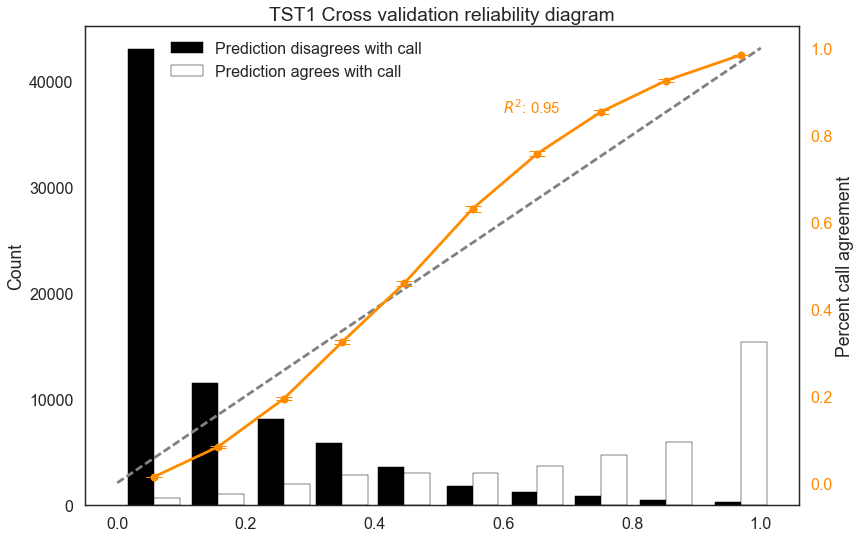

In [125]:
create_reliability_diagram(probabilities, labels,['Ambiguous','Fail','Somatic'], 'darkorange', 'TST1 Cross validation reliability diagram')

In [58]:
forest_and_half_tst1 = estimator.fit(X_tst1,Y_tst1)

In [59]:
tst1_probs = forest_and_half_tst1.predict_proba(tst1_features_test)

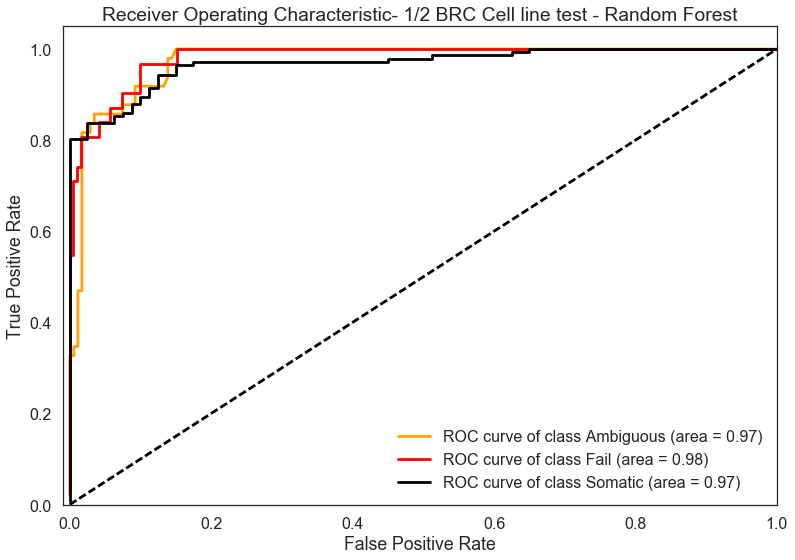

In [60]:
create_roc_curve(enc.fit_transform(tst1_calls_test), tst1_probs, 
                 class_lookup, 'Receiver Operating Characteristic- 1/2 BRC '
                 'Cell line test - Random Forest')

In [ ]:
create_reliability_diagram(tst1_probs, enc.fit_transform(tst1_calls_test),
                           ['Ambiguous','Fail','Somatic'], 
                           'darkorange', 'Reliability diagram - 1/2 BRC '
                           'Cell line test - Random Forest')

# Hold out test set

In [61]:
three_class = training_data.replace('g','f')

In [62]:
three_class.groupby('call').size()

call
a    14718
f     5910
s    21159
dtype: int64

In [63]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array, drop reviewer and call
X = three_class.drop(three_class.columns[39:43].tolist() + ['call'], axis=1).astype(float).values

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [65]:
X_train.shape

(27997, 67)

In [66]:
Y_train.shape

(27997,)

In [67]:
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [68]:
Y_train_labels = enc.fit_transform(Y_train)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [69]:
print_accuracy_and_classification_report(Y_train_labels, predict_classes(probabilities))

Cross validation accuracy:
	 0.829660320749

Cross validation classification report

             precision    recall  f1-score   support

          0       0.82      0.78      0.80      9948
          1       0.68      0.77      0.72      3938
          2       0.89      0.88      0.88     14111

avg / total       0.83      0.83      0.83     27997



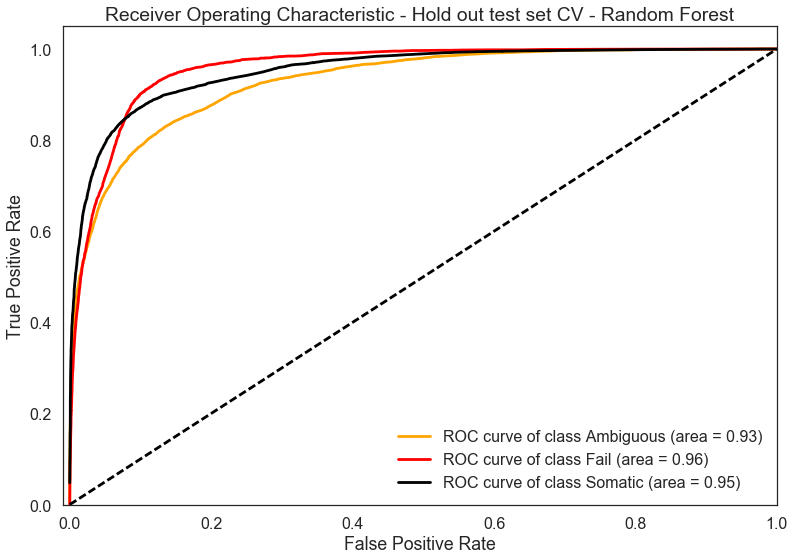

In [70]:
create_roc_curve(Y_train_labels, probabilities, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set CV - '
                 'Random Forest')

confidence intervals +-:  [ 0.00064658  0.00301541  0.00470128  0.00608662  0.00724835  0.00841932
  0.00732278  0.00592333  0.00389957  0.00119344]


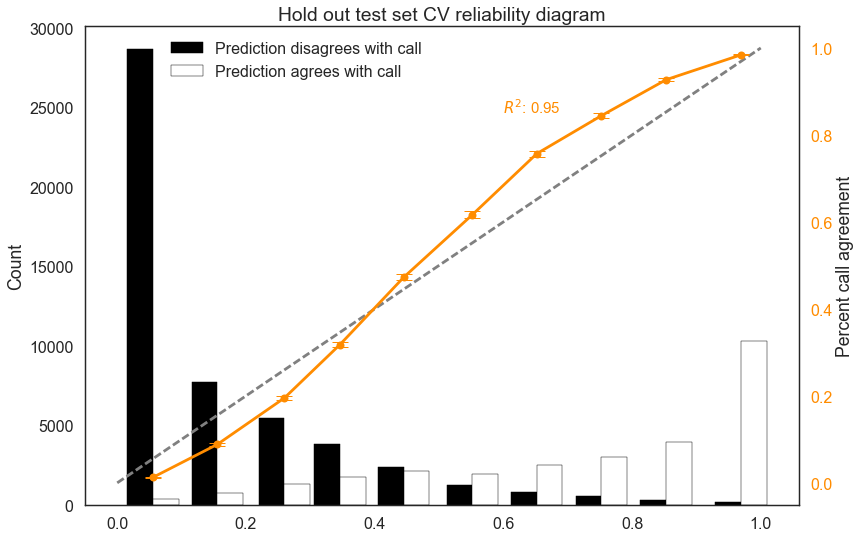

In [72]:
create_reliability_diagram(probabilities, Y_train_labels,['Ambiguous','Fail','Somatic'], 'darkorange', 'Hold out test set CV reliability diagram')

In [73]:
forest = estimator.fit(X_train, Y_train)

In [74]:
test_prob = forest.predict_proba(X_test)

In [75]:
Y_test_labels = enc.fit_transform(Y_test)

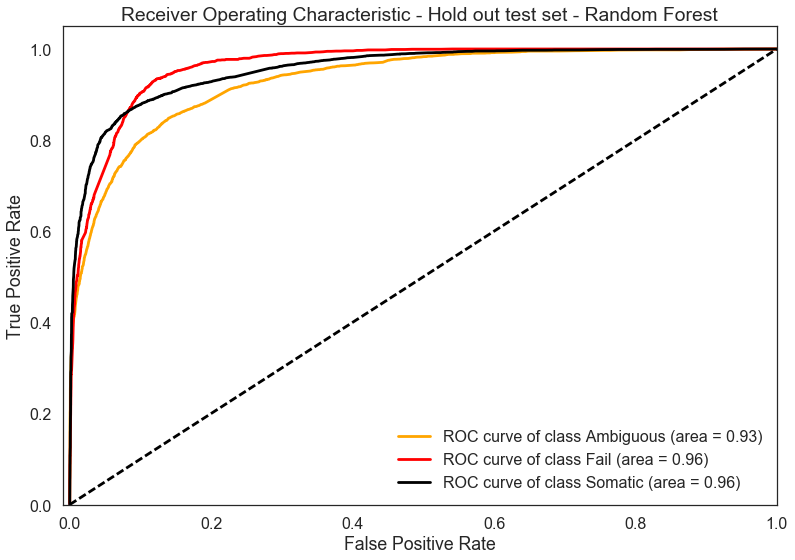

In [76]:
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'Random Forest')

In [ ]:
create_reliability_diagram(test_prob, Y_test_labels,
                           ['Ambiguous','Fail','Somatic'], 
                           'darkorange', 'Reliability diagram - Hold out test set '
                           '- Random Forest')